<a href="https://colab.research.google.com/github/DataMinati/Super-Notebooks-100/blob/main/Patient_Survival_Predictor_(using_Pytorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dependency**

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# **Code Block - Preprocessing**

In [2]:
# solve_missing {'drop' , 'mean', 'median'}
def clean_data(dataframe, 
               solve_missing : str ='drop', 
               solve_missing_cat : str = 'drop',
               drop_list : list = [], 
               category_list : list = []): 
    df = dataframe.drop_duplicates()
    df = df.drop(drop_list, axis=1)
    if solve_missing == 'drop' or solve_missing_cat == 'drop':
        df = df.dropna()
        object_dtype = list(df.select_dtypes(include='object').columns)
        for col in df.columns:
            if col in category_list or col in object_dtype:
                df[col] = df[col].astype('category')
    else:
        object_dtype = list(df.select_dtypes(include='object').columns)
        for col in df.columns:
            if col in category_list or col in object_dtype:
                df[col] = df[col].astype('category')
                if solve_missing_cat == 'mode':
                    df[col] = df[col].fillna(df[col].mode()[0], inplace=False)
            else:
                if solve_missing == 'mean':
                    df[col] = df[col].fillna(df[col].mean(), inplace=False)
                else:
                    df[col] = df[col].fillna(df[col].median(), inplace=False)
    return df

def split_xy(dataframe, label : str):
    return dataframe.drop(labels=label, axis=1), dataframe[label]

def encode(df):
    category_dtype = list(df.select_dtypes(include='category').columns)
    cat = pd.get_dummies(df, columns = category_dtype, drop_first = True)
    for col in cat.columns:
        if cat[col].dtype == np.uint8:
            cat[col] = cat[col].astype('category')
    return cat

def scale(features : tuple):
    trainFeatures, valFeatures, testFeatures = features # type pandas DataFrame
    scaler = StandardScaler()
    category_dtype = list(trainFeatures.select_dtypes(include='category').columns)
    continuous_dtype = list(filter(lambda c: c not in category_dtype, trainFeatures.columns))
    # SCALING
    scaler.fit(trainFeatures[continuous_dtype])
    cont_xtrain = scaler.transform(trainFeatures[continuous_dtype])
    cont_xval = scaler.transform(valFeatures[continuous_dtype])
    cont_xtest = scaler.transform(testFeatures[continuous_dtype])
    # ENCODING
    cat_xtrain = trainFeatures[category_dtype]
    cat_xval = valFeatures[category_dtype]
    cat_xtest = testFeatures[category_dtype]
    print(cat_xtrain.shape, cat_xval.shape, cat_xtrain.shape)
    xtrain = np.concatenate((cont_xtrain, cat_xtrain), axis=1)
    xval = np.concatenate((cont_xval, cat_xval), axis=1)
    xtest = np.concatenate((cont_xtest, cat_xtest), axis=1)
    return scaler, xtrain, xval, xtest

# **Data Loading**

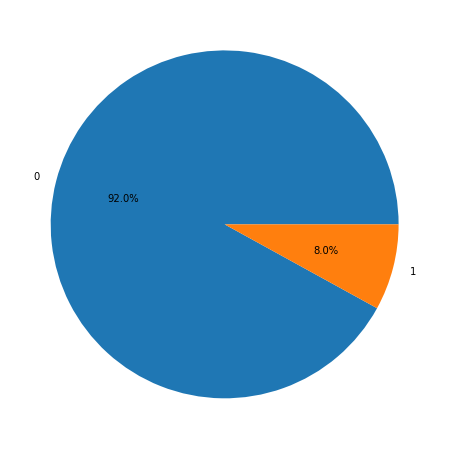

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/MainakRepositor/Datasets-/master/patient_survival.csv')
TARGET = 'hospital_death'

#df.info()
plt.figure(figsize=(10,8))
unique_labels = np.unique(df[TARGET])
plt.pie(np.array([len(df[df[TARGET]==label]) for label in unique_labels ]), labels = list(unique_labels), autopct='%1.1f%%')
plt.show()

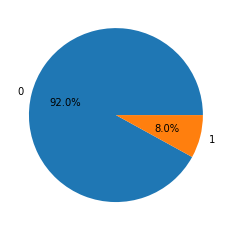

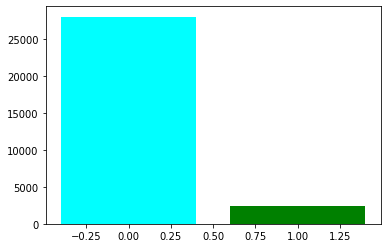

In [7]:
category_list = ['elective_surgery', 'ethnicity', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem', 
                 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'hospital_death']
drop_list = ['encounter_id', 'patient_id', 'hospital_id', 'Unnamed: 83']

clean_df = clean_data(df, 'mean', 'mode', drop_list, category_list)
plt.pie(np.array([len(clean_df[clean_df[TARGET]==label]) for label in unique_labels ]), labels = list(unique_labels), autopct='%1.1f%%')
plt.show()
plt.bar(list(unique_labels), [len(clean_df[clean_df[TARGET]==label]) for label in unique_labels ], color = ['cyan', 'green'])
plt.show()

In [ ]:
features, labels = split_xy(clean_df, TARGET)
VAL_SIZE = 0.2
TEST_SIZE = 0.3
encoded_features = encode(features)
print('Encoded Features Shape : {}'.format(encoded_features.shape))
# split all samples to train and test with respect to the ratio of each class
X_train, X_test, ytrain, ytest = train_test_split(encoded_features, labels, test_size = (VAL_SIZE+TEST_SIZE), stratify = labels)
# split test sample to test and validation with respect to the ratio of each class
X_test, X_val, ytest, yval = train_test_split(X_test, ytest, test_size = VAL_SIZE/(VAL_SIZE+TEST_SIZE), stratify = ytest)
# scale continous variables with standard scaler
scaler, xtrain, xval, xtest = scale((X_train, X_val, X_test))
#print(scaler.mean_)
#print(scaler.var_)
#print(xtrain.shape, ytrain.shape)
#print(xval.shape, yval.shape)
#print(xtest.shape, ytest.shape)
# convert features to numpy array format
xtrain = np.array(xtrain, dtype='float32')
xval = np.array(xval, dtype='float32')
xtest = np.array(xtest, dtype='float32')
ytrain = np.array(ytrain, dtype='float32')
yval = np.array(yval, dtype='float32')
ytest = np.array(ytest, dtype='float32')

Encoded Features Shape : (91713, 111)
(45856, 47) (18343, 47) (45856, 47)


# **Model**

In [ ]:
import torch
# locate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch.nn.functional as F
import torch.nn as nn
#from torch.autograd import Variable

class Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 1024)
        self.gnorm1 = nn.GroupNorm(32, 1024)
        
        self.layer2 = nn.Linear(1024, 512)
        self.gnorm2 = nn.GroupNorm(16, 512)
        
        self.layer3 = nn.Linear(512, 128)
        self.gnorm3 = nn.GroupNorm(4, 128)
        self.layer4 = nn.Linear(128, output_dim)
        
    def forward(self, x):
        x = F.relu(self.gnorm1(self.layer1(x)))
        x = F.relu(self.gnorm2(self.layer2(x)))
        x = F.relu(self.gnorm3(self.layer3(x)))
        x = torch.sigmoid(self.layer4(x))
        return x

# **Code Block - Convert Dataset to PyTorch Compatible Dataset**

In [ ]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, x, y, device):
        self._x = x
        self._y = y
        self._device = device

    def __len__(self):
        return len(self._x)

    def __getitem__(self, idx):
        X, Y = self._x[idx], self._y[idx].ravel()
        return torch.as_tensor(X, dtype=torch.float32, device=self._device), torch.as_tensor(Y, dtype=torch.float32, device=self._device)

In [ ]:
# batch size of train, validation, test don't have to be the same
TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, TEST_BATCH_SIZE = 256, 256, 1

train_dataset = CustomDataset(xtrain, ytrain, device)
val_dataset = CustomDataset(xval, yval, device)
test_dataset = CustomDataset(xtest, ytest, device)

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

# **Declare Metrics to Monitor and Load to Device**

In [ ]:
# unable to import F1Score
from torchmetrics import Accuracy, MeanSquaredError, Precision, Recall
if torch.cuda.is_available():
    loss_fn   = nn.BCELoss().cuda()
    metrics = [
        {'name': 'Accuracy', 'fn' : Accuracy().cuda(), 'type' : 'int'},
        {'name': 'MeanSquaredError', 'fn': MeanSquaredError().cuda(), 'type' : 'float'},
        {'name': 'Precision', 'fn': Precision().cuda(), 'type': 'int'},
        {'name': 'Recall', 'fn': Recall().cuda(), 'type':'int'}
    ]
else:
    loss_fn = nn.BCELoss().cpu()
    metrics = [
        {'name': 'Accuracy', 'fn' : Accuracy().cpu(), 'type' : 'int'},
        {'name': 'MeanSquaredError', 'fn': MeanSquaredError().cpu(), 'type' : 'float'},
        {'name': 'Precision', 'fn': Precision().cpu(), 'type' : 'int'},
        {'name': 'Recall', 'fn': Recall().cpu(), 'type' : 'int'}
    ]

In [ ]:
model     = Model(xtrain.shape[-1], 1)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

In [ ]:
def L1(params, device, l1 = 0.0001):
    reg = torch.tensor(0., device=device)
    for param in params:
        reg += torch.sum(torch.abs(param))
    return l1 * reg

def L2(params, device, l2 = 0.0001):
    reg = torch.tensor(0., device=device)
    for param in params:
        reg += torch.sum(torch.pow(param, 2))
    return l2 * reg

def train_loop(dataloader, valloader, model, loss_fn, optimizer, max_iter, metrics : dict, device):
    model.train()
    history = dict()
    history['Loss'] = []
    history['val_Loss'] = []
    for m in metrics:
        history[m['name']] = []
        history['val_{}'.format(m['name'])] = []
    size = len(dataloader.dataset)
    for itr in range(max_iter):
        real_time = dict()
        real_time['Loss'] = []
        for m in metrics:
            real_time[m['name']] = []
        for batch, (X, y) in enumerate(dataloader):
            # Compute prediction and loss
            X.to(device)
            y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            loss += L2(model.parameters(), device) + L1(model.parameters(), device)
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # compute metrics
            real_time['Loss'].append(loss.item())
            for m in metrics:
                if m['type'] == 'float':
                    real_time[m['name']].append(m['fn'](pred, y).item())
                else:
                    real_time[m['name']].append(m['fn'](pred, y.type(torch.uint8)).item())
        history['Loss'].append(np.mean(real_time['Loss']))
        for m in metrics:
            history[m['name']].append(np.mean(real_time[m['name']]))
            print(f"{m['name']}: {np.mean(real_time[m['name']]):>8f}", end='\t')
        print('')
        epoch_loss = np.mean(real_time['Loss'])
        print(f"Loss: {epoch_loss:>7f} [{itr:>5d}/{max_iter:>5d}]")
        print('Val', end = '\t')
        tmp = dict()
        tmp['Loss'] = []
        for m in metrics:
            tmp[m['name']] = []
        model.eval()
        with torch.no_grad():
            for X, y in valloader:
                X.to(device)
                y.to(device)
                pred = model(X)
                test_loss = loss_fn(pred, y)
                tmp['Loss'].append(test_loss.item())
                for m in metrics:
                    if m['type'] == 'float':
                        tmp[m['name']].append(m['fn'](pred, y).item())
                    else:
                        tmp[m['name']].append(m['fn'](pred, y.type(torch.uint8)).item())
        for k, v in tmp.items():
            print(f"{k}: {np.mean(v):>8f}", end='\t')
            history['val_{}'.format(k)].append(np.mean(v))
        print('###END')
        #torch.save(model, f'./model_E{itr:>5d}.pt')
    return history

def test_loop(dataloader, model, loss_fn, metrics : dict, device):
    score = dict()
    tmp = dict()
    tmp['Loss'] = []
    for m in metrics:
        tmp[m['name']] = []
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X.to(device)
            y.to(device)
            pred = model(X)
            test_loss = loss_fn(pred, y)
            tmp['Loss'].append(test_loss.item())
            for m in metrics:
                if m['type'] == 'float':
                    tmp[m['name']].append(m['fn'](pred, y).item())
                else:
                    tmp[m['name']].append(m['fn'](pred, y.type(torch.uint8)).item())
    for k, v in tmp.items():
        print(f"{k}: {np.mean(v):>8f}", end='\t')
        score[k] = np.mean(v)
    return score

def predict(dataloader, model, device):
    ypred = []
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X.to(device)
            pred = model(X)
            ypred.append([torch.ravel(pred), torch.ravel(y)])
    return ypred

# **Train**

In [ ]:
EPOCHS = 50
train_history = train_loop(train_loader, val_loader, model, loss_fn, optimizer, EPOCHS, metrics, device)

Accuracy: 0.815408	MeanSquaredError: 0.189324	Precision: 0.064894	Recall: 0.112541	
Loss: 2.464778 [    0/   50]
Val	Loss: 0.454103	Accuracy: 0.913712	MeanSquaredError: 0.135534	Precision: 0.013889	Recall: 0.000661	###END
Accuracy: 0.913520	MeanSquaredError: 0.111507	Precision: 0.000000	Recall: 0.000000	
Loss: 2.290220 [    1/   50]
Val	Loss: 0.350884	Accuracy: 0.913712	MeanSquaredError: 0.094809	Precision: 0.000000	Recall: 0.000000	###END
Accuracy: 0.914128	MeanSquaredError: 0.087392	Precision: 0.000000	Recall: 0.000000	
Loss: 2.220771 [    2/   50]
Val	Loss: 0.309750	Accuracy: 0.913712	MeanSquaredError: 0.082276	Precision: 0.000000	Recall: 0.000000	###END
Accuracy: 0.913824	MeanSquaredError: 0.079618	Precision: 0.000000	Recall: 0.000000	
Loss: 2.190453 [    3/   50]
Val	Loss: 0.289990	Accuracy: 0.913712	MeanSquaredError: 0.077393	Precision: 0.000000	Recall: 0.000000	###END
Accuracy: 0.913368	MeanSquaredError: 0.076355	Precision: 0.000000	Recall: 0.000000	
Loss: 2.173694 [    4/   50]

# **Evaluate**

In [ ]:
score = test_loop(test_loader, model, loss_fn, metrics, device)

Loss: 0.209250	Accuracy: 0.925747	MeanSquaredError: 0.058181	Precision: 0.024133	Recall: 0.024133	

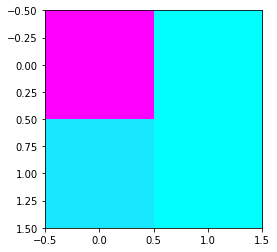

Confusion Matrix
[[25139     0]
 [ 2375     0]]


In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

ypred = predict(test_loader, model, device)
ypred_np = np.array(ypred, dtype='int64')
predictions, gt = ypred_np[:,0], ypred_np[:,1]

cfm = confusion_matrix(gt, predictions)
plt.imshow(cfm, cmap='cool', interpolation='nearest')
plt.show()

print('Confusion Matrix')
print(cfm)

# **Analysis**

In [ ]:
import matplotlib.pyplot as plt

5


Text(0, 0.5, 'Loss')

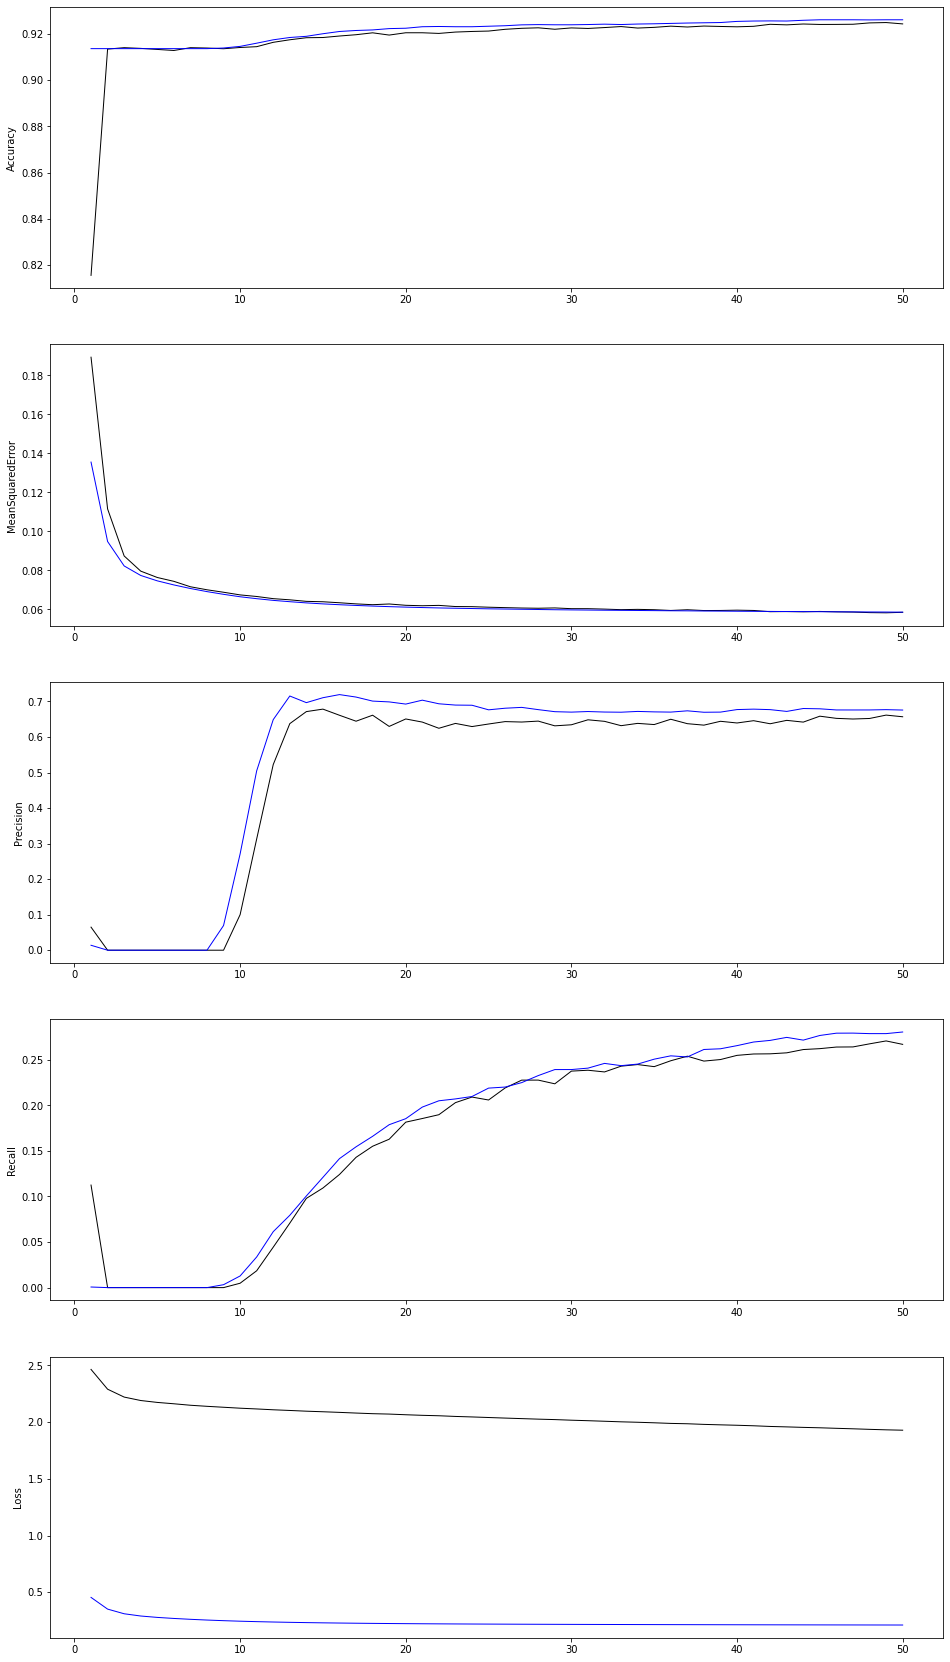

In [ ]:
fig = plt.gcf()
fig.set_size_inches(16, 30)
plt.figure(1)

nplot = len(train_history.keys()) // 2
print(nplot)
for idx, m in enumerate(metrics, 0):
    plt.subplot(nplot*100+10+idx+1)
    plt.plot([i+1 for i in range(len(train_history[m['name']]))], train_history[m['name']], color='black', linewidth=1)
    plt.plot([i+1 for i in range(len(train_history[m['name']]))], train_history['val_{}'.format(m['name'])], color='blue', linewidth=1)
    ax = plt.gca()
    ax.set_ylabel(m['name'])
plt.subplot(nplot*100+10+nplot)
plt.plot([i+1 for i in range(len(train_history['Loss']))], train_history['Loss'], color='black', linewidth=1)
plt.plot([i+1 for i in range(len(train_history['val_Loss']))], train_history['val_Loss'], color='blue', linewidth=1)
ax = plt.gca()
ax.set_ylabel('Loss')
